![data-x](https://raw.githubusercontent.com/afo/data-x-plaksha/master/imgsource/dx_logo.png)


# Data-X: Introduction to TensorFlow
### Computation Graphs, Simple One Layer ANN, Vanilla DNN

**Author:** Alexander Fred Ojala

**Sources:** Sebastian Raschka, Aurélien Géron, etc.

**Copright:** Feel free to do whatever you want with this code.

___

# General notebook setup
Make notebook compatible with Python 2 and 3, plus import standard packages.

In [1]:
# Pyton 2 and 3 support
from __future__ import division, print_function, unicode_literals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Intro to TensorFlow
### Core components:

#### 1. Tensor
A Tensor in TensorFlow is an N-dimensional array (just like Numpys array object). Tensors are multilinear maps from vector spaces to real numbers. Scalars, vectors and matrices are all tensors. Think of tensors as a multi-dimensional array. The Tensor represents units of data in TensorFlow.

Numpy arrays are automatically converted into TensorFlow tensors. They cannot be inserted into tensor functions, can’t automatically compute derivatives and computations cannot automatically be sent to a GPU. (However, it is usually simple to do quick computations in NumPy).

#### 2. Operations / Ops
TensorFlow operations or ops are units / edges / nodes of computation (e.g. matrix multiplication, addition, etc.)

#### 3. Computation Graph
The computational graph is the core component of TensorFlow it represents the dataflow and the order of computations. First we build a graph (nothing is calculated), then this computation graph is  sent to aa runtime environment (e.g. on a CPU or GPU) for execution. The results are sent back to us. This makes TensorFlow computations highly distributable and because the graphs store symbolic representations of the operations it also allows us to automatically evaluate all gradients in the computation nodes.

![](imgs/tf_graph.png)

(C) CS20

## **TensorFlow benefits:**
- Highly efficient (computations can be parallellized)
- Cross-platform (works on IOS, Android, Unix, Windows, in the cloud etc etc)
- Calculates gradients automatically (this is truly useful for Neural Networks, where the analytical solution of gradients would be VERY tedious to derive).

In [3]:
# Canonical way of importing TensorFlow
import tensorflow as tf

# If this doesn't work TensorFlow is not installed correctly

In [4]:
# Check tf version, oftentimes tensorflow is not backwards compatible
tf.__version__

'1.11.0'

Recommendation: When using Jupyter notebook make sure to call tf.reset_default_graph() at the beginning to clear the symbolic graph before defining new nodes.

In [5]:
tf.reset_default_graph()

# TensorBoard setup
Tip2: Setup TensorBoard to monitor graph etc

In [6]:
from datetime import datetime
import os
import pathlib

t = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
log_dir = "tf_logs"
logd = "/tmp/{}/r{}/".format(log_dir, t)

# Then every time you have specified a graph run:
# file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Make directory if it doesn't exist

from pathlib import Path
home = str(Path.home())

logdir = os.path.join(os.sep,home,logd)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [7]:
# TensorBoard Graph visualizer in notebook
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# 1. TensorFlow tensors

TensorFlow operations are not executed directly, but rather they are placed in a logical order in a computation graph. In order to evaluate them, we have to run them in a session (shown later).

## 1.1 tf.constant

Constants are initialized directly and we cannot change the value

In [8]:
a = tf.constant(2)
b = tf.constant(5)

In [9]:
a

<tf.Tensor 'Const:0' shape=() dtype=int32>

In [11]:
# tensors can also have names (in the computation graph)
named_tensor = tf.constant(7.2, name='my_named_tuple')
named_tensor

<tf.Tensor 'my_named_tuple_1:0' shape=() dtype=float32>

## 1.2 tf.placeholder

Placeholders can be fed an arbitrary or specified amount of data at anytime in the execution flow. They are not initialized directly, but need a data source.

In [12]:
# note that we have to specify a data type
# just as for the numpy array
# shape is optional
# here 3 columns, arbitrary number of rows
c = tf.placeholder(dtype=tf.float64,shape=[None,3])
c

<tf.Tensor 'Placeholder:0' shape=(?, 3) dtype=float64>

TensorFlow datatypes: https://www.tensorflow.org/api_docs/python/tf/DType

## 1.3 tf.Variable

A Variable is NOT initiliazed directly, but have to be initialzed in the session. The variables can also be updated and reassigned new values. Variables are usually all the weights and biases that are optimized during training, they also indicate the degrees of freedom of the model (what model parameters that can change, thus making the model flexible).

In [13]:
d = tf.Variable(np.random.randn(3).reshape(3,1)) #reshape
# automatically assings data type
d #

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float64_ref>

<div class='alert alert-info'>Tensorflow is really similar to NumPy, and you can think of the tensors as an ndimensional array.</div>


![tf_to_np](imgs/tf_to_np.png)
Source: CS227d, NLP, Stanford

# 2. Operations / Ops
Operations can be carried out directly or assigned to variables. If they are assigned to variables, the variable will be an operation node in the computational graph.

In [14]:
op1 = tf.add(a,b) # nothing happens
op1

<tf.Tensor 'Add:0' shape=() dtype=int32>

In [16]:
opx = tf.add(op1,a,name='opx_add')

In [17]:
show_graph(tf.get_default_graph())

In [18]:
a+b # same as tf.add, here the operation is not saved in the computation graph

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [19]:
# We can specify ops on arrays and matrices
# however the shapes have to be adequate

# Here we do an operation on a placeholder and a Variable
# Same as (functional maps)
print('c.shape=',c.shape, 'd.shape=',d.shape)

c.shape= (?, 3) d.shape= (3, 1)


In [21]:
op2 = tf.matmul(c,d) # note we have to "feed data" to d when we evaluate this
op2

<tf.Tensor 'MatMul_1:0' shape=(?, 1) dtype=float64>

# TensorFlow graphs, calculations & executions

Graph based computations are powerful, because the computations can be split up and run in parallell really easy. For example:

* a = b + c
* d = b + 2

These two computations can be sent to different CPUs / GPUs. These gains are remarkable for complex NNs such as CNNs and RNNs.

____

Graph based computations also allow tensorflow to implement solutions for automatic gradient calculations at every node (as we're working with symbolic computational graphs). TensorFlow builds a graph first in order to do formal full gradient calculation on all nodes (before running / executing the operations).

# Evaluate nodes and operations with `tf.Session()` objects

Use the `.run()` method on a Session and evaluate tensors and execute operations.

In [23]:
sess = tf.Session() # start a session

# A session object encapsulates the environment where we evaluate tensors and execute ops

In [24]:
b

<tf.Tensor 'Const_1:0' shape=() dtype=int32>

In [25]:
sess.run(b)

5

In [26]:
sess.run(tf.add(a,b))

7

In [28]:
f = tf.Variable(99, name = 'f')
sess.run(f.initializer) # !!! error if we don't
sess.run(f)

99

### Global Variable Initialization

In [29]:
f1 = tf.Variable(11)
f2 = tf.get_variable("f2", initializer=tf.constant(22)) #another efficient way to create a variable

In [31]:
# This is tedious if we have many variables

# Instead initialize all variables globally
sess.run(tf.global_variables_initializer())

In [32]:
sess.run(f2)

22

In [33]:
sess.run(f1+f2)

33

# Feed data to placeholders with dictionary

In [42]:
# we must feed the placeholder node c data
tmp_data = np.array([[3,2,1],[1,2,3]])
tmp_data.shape

(2, 3)

In [43]:
c.get_shape()

TensorShape([Dimension(None), Dimension(3)])

In [44]:
sess.run(c, feed_dict={c:tmp_data})

array([[3., 2., 1.],
       [1., 2., 3.]])

### More complex computational graph

In [47]:
v = a+b
u = v+2
w = v*u
z = w*3
z

<tf.Tensor 'mul_3:0' shape=() dtype=int32>

In [48]:
# If we run z then tensorflow will recognize that it has to evaluate
# w, u and v in order to get the result ofz
sess.run(z)

189

**Note:** We defined operations v, u and w which need to be calculated before we can figure out what z is.  However, we don’t have to explicitly run those operations, as TensorFlow knows what other operations and variables the operation a depends on, and therefore runs the necessary operations on its own.  It does this through its data flow graph which shows it all the required dependencies.

## `with` sessions
Oftentimes you will also see sessions defined within a `with` environment. This is great when you want to send computations to different run time environments.

In [49]:
with tf.Session() as sess2:
    print(sess2.run(a+b))

7


### Namescopes to group computations

In [56]:
graph3 = tf.Graph()

with graph3.as_default():

    with tf.name_scope('const_add1') as scope:
        x = tf.constant(2, name='x')
        y = tf.constant(3, name='y')
        z = tf.multiply(x,y, name='z')
    with tf.name_scope('second') as scope:
        w1 = tf.add(z, 3, name='w1')
        w2 = z - 4
    sess3 = tf.Session(graph=graph3)
    print(sess3.run(w1))
    print(sess3.run(w2))



9
2


In [51]:
show_graph(graph3)

# Launch Tensorboard from Terminal

In [57]:
logdir

'/tmp/tf_logs/r20181030195855/'

In [58]:
# write graph as TensorBoard file
file_writer = tf.summary.FileWriter(logdir, graph3)

In [59]:
# run tensorboard
# NOTE: You could do this in the terminal (recommended)
# You have to interrupt kernel to continue executions

!tensorboard --logdir=$logdir

W1030 13:29:41.706791 Reloader tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W1030 13:29:41.706791 140119053956864 tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
TensorBoard 1.11.0 at http://localhost:6006 (Press CTRL+C to quit)
W1030 13:29:43.763508 Thread-1 application.py:300] path /[[getImageSrc(feat.name)]] not found, sending 404
W1030 13:29:43.763508 140119045302016 application.py:300] path /[[getImageSrc(feat.name)]] not found, sending 404
W1030 13:29:43.765349 Thread-1 application.py:300] path /[[getCompareImageSrc(feat.name)]] not found, sending 404
W1030 13:29:43.765349 140119045302016 application.py:300] path /[[getCompareImageSrc(feat.name)]] not found, sending 404
W1030 13:29:43.767797 Th

# Linear Regression in TensorFlow


In [60]:
# Variables can be chosen as model parameters
# TensorFlow can help us optimize them
# by automatically calculating the gradient

# Let's try to fit a simple lienar regression model
# y = theta_0 + theta_1 * x
tf.reset_default_graph() # reset graph

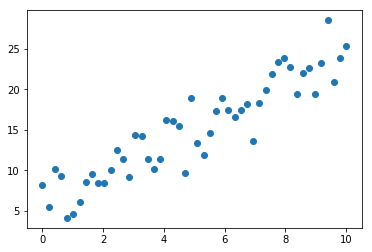

In [62]:
# Create data we want to fit to:

x_real = np.linspace(0,10)
y_real = 5.0 + 2.0*x_real + np.random.normal(0,2,len(x_real),)

plt.scatter(x_real, y_real)

# Contruction Phase

In [63]:
# Initialize the variables at random values
theta0 = tf.Variable(.1, dtype=tf.float32, name='bias')
theta1 = tf.Variable(.3, dtype=tf.float32, name='weight')

x = tf.placeholder(tf.float32, name='x')
y = tf.placeholder(tf.float32, name='y') # placeholder for ground truth

In [64]:
# Define the model as a variable
linear_model = theta0 + theta1*x

In [65]:
# Variables are not initialized when we call tf.Variable
# To initialize them we must tell TensorFlow to do it
theta0

<tf.Variable 'bias:0' shape=() dtype=float32_ref>

In [66]:
# initialize all variables in a session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [67]:
# Since x is a placeholder, we can evaluate linear_model for
# several values of x
sess.run(linear_model, {x: range(5)})

# only after we have initialized the Variables

array([0.1       , 0.4       , 0.70000005, 1.        , 1.3000001 ],
      dtype=float32)

In [68]:
# Define a loss function, so that we can evaluate
# how good our model is and train it

SE = tf.square(linear_model - y) # square elements
loss = tf.reduce_sum(SE) # Mean Squared Error
dictfeed = {x: x_real, y: y_real}

sess.run(loss, dictfeed)

# the loss is really high!

10567.717

In [69]:
# The loss was really big for those parameters.
# We can also reassign the values of the weights
theta0_update = tf.assign(theta0, 2)
theta1_update = tf.assign(theta1, 2)
sess.run([theta0_update, theta1_update]) # run the assign operation
# to update the variables

sess.run(loss, dictfeed)
# reduced loss # closer to the real values, still really high!

780.0614

TensorFlow provides optimizers that slowly change each variable in order to minimize the loss function. The simplest optimizer is gradient descent. It modifies each variable according to the magnitude of the derivative of loss with respect to that variable. 

In general, computing symbolic derivatives manually is tedious and error-prone. Consequently, TensorFlow can automatically produce derivatives given only a description of the model using the function tf.gradients. For simplicity, optimizers typically do this for you.

In [70]:
# Train the model with GradientDescent iteratively
optimizer = tf.train.GradientDescentOptimizer(learning_rate = .0001)

# train step
train = optimizer.minimize(loss) # training step

# Evaluation Phase

In [71]:
sess.run(tf.global_variables_initializer()) # init operation re-initilize weight values
sess.run([theta0,theta1])

[0.1, 0.3]

In [72]:
for i in range(5000):
    sess.run(train, {x: x_real, y: y_real})
    # here is where the magic happens, the gradients are calculated 
    # and the weights / variables are updated in every iteration
    # in accordance with a step in the negative 
    # gradient's direction according scaled by the learning rate


In [73]:
b,W = sess.run([theta0, theta1]) # correct values are 5 and 2
print(b,W)

5.8216257 1.8729258


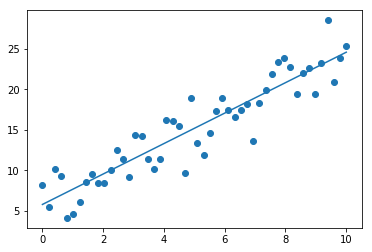

In [74]:
plt.scatter(x_real,y_real)
plt.plot(x_real, b+W*x_real)

In [75]:
show_graph(tf.get_default_graph())

# MNIST: Intro to NN in TensorFlow

Example taken from Google Docs

We are now going to recognize hand-written digits.

![https://www.tensorflow.org/images/MNIST.png](https://www.tensorflow.org/images/MNIST.png)

# About the most classic NN dataset
The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation). This split is very important: it's essential in machine learning that we have separate data which we don't learn from so that we can make sure that what we've learned actually generalizes!

Every MNIST data point has two parts: an image of a handwritten digit and a corresponding label. We'll call the images "x" and the labels "y". Both the training set and test set contain images and their corresponding labels; for example the training images are mnist.train.images and the training labels are mnist.train.labels.

Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:

![https://www.tensorflow.org/images/MNIST-Matrix.png](https://www.tensorflow.org/images/MNIST-Matrix.png)

We can flatten this array into a vector of 28x28 = 784 numbers. It doesn't matter how we flatten the array, as long as we're consistent between images. From this perspective, the MNIST images are just a bunch of points in a 784-dimensional vector space, with a very rich structure (warning: computationally intensive visualizations).

Flattening the data throws away information about the 2D structure of the image. Isn't that bad? Well, the best computer vision methods do exploit this structure, and we will in later tutorials. But the simple method we will be using here, a softmax regression (defined below), won't.

The result is that mnist.train.images is a tensor (an n-dimensional array) with a shape of [55000, 784]. The first dimension is an index into the list of images and the second dimension is the index for each pixel in each image. Each entry in the tensor is a pixel intensity between 0 and 1, for a particular pixel in a particular image.

![https://www.tensorflow.org/images/mnist-train-xs.png](https://www.tensorflow.org/images/mnist-train-xs.png)

Each image in MNIST has a corresponding label, a number between 0 and 9 representing the digit drawn in the image.

For the purposes of this tutorial, we're going to want our labels as "one-hot vectors". A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the $n$th digit will be represented as a vector which is 1 in the $n$th dimension. For example, 3 would be $[0,0,0,1,0,0,0,0,0,0]$. Consequently, mnist.train.labels is a [55000, 10] array of floats.

# Softmax regression

We know that every image in MNIST is of a handwritten digit between zero and nine. So there are only ten possible things that a given image can be. We want to be able to look at an image and give the probabilities for it being each digit. For example, our model might look at a picture of a nine and be 80% sure it's a nine, but give a 5% chance to it being an eight (because of the top loop) and a bit of probability to all the others because it isn't 100% sure.

This is a classic case where a softmax regression is a natural, simple model. If you want to assign probabilities to an object being one of several different things, softmax is the thing to do, because softmax gives us a list of values between 0 and 1 that add up to 1. Even later on, when we train more sophisticated models, the final step will be a layer of softmax.

A softmax regression has two steps: first we add up the evidence of our input being in certain classes, and then we convert that evidence into probabilities.

**Softmax regression equation**

$$\sigma (\mathbf {z} )_{j}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}}\ for\ j = 1, …, K$$

where $z$ represents the values from the output layer and $K$ represents the number of output classes.

To tally up the evidence that a given image is in a particular class, we do a weighted sum of the pixel intensities. The weight is negative if that pixel having a high intensity is evidence against the image being in that class, and positive if it is evidence in favor.

The following diagram shows the weights one model learned for each of these classes. Red represents negative weights, while blue represents positive weights.

![https://www.tensorflow.org/images/softmax-weights.png](https://www.tensorflow.org/images/softmax-weights.png)

# (Vanilla) DNN Network structure
* Any Neural Network with one hidden layer can be a Universal Function Approximator. Source: [https://en.wikipedia.org/wiki/Universal_approximation_theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)
* The number of input nodes are equal to the number of features
* The number of output nodes are equal to the number of classes (for classification tasks)
* A bias term is added to every layer that only feeds in a constant value, that adds an extra degree of freedom for every functional input value to the next function

# How deep should we go?
* We can overfit Neural Nets, one way to combat that is by using dropout and regularization
* Predictions will usually be better when we increase depth of network and widen it (increase the number of neurons in every layer)

# Activation Functions
* Classically the sigmoid function was used in the hidden layers (simplest function between 0 - 1). Logit function.
* Nowadays it is more common to use the ReLU (Rectified Linear Unit). Much quicker! For deep networks sigmoid might not want to converge at all. Much better to handle exploding and vanishing gradients (Leaky Relu). Can also combat that with *Batch Normalization*.
* For the input layer we send in the (standardized) values.
* For the output layer we often use a softmax function (multi-class classification) or a sigmoid function (binary classification). Softmax only works if the classes are mutually exclusive, i.e. we only try to label one pattern in every training example.


# Training algorithm steps
* Train a model to make a prediction
* Compute distance between predictions and true values
* Modify weights and biases to lower error


# Overfitting
* Mostly because our network has too many degrees of freedom (neurons in the network)
* Can use L1 and L2 regularization on the cost function
* Drop out (used to mitigate the effects of too many degrees of freedom)

# DNNs are not great at classifying images
* We don't make use of the image shapes and curves. Shape info is lost when we flatten arrays.

_____

_____

# ANN One Layer Softmax Classification

What we will accomplish in this section:

- Create a softmax regression function that is a model for recognizing MNIST digits, based on looking at every pixel in the image
- Use Tensorflow to train the model to recognize digits by having it "look" at thousands of examples (and run our first Tensorflow session to do so)
- Check the model's accuracy with our test data

In [76]:
# Read in input data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# contains info
import tensorflow.examples.tutorials.mnist.mnist as mnist_info


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Here `mnist` is a lightweight class which stores the training, validation, and testing sets as NumPy arrays. It also provides a function for iterating through data minibatches, which we will use below.

In [77]:
!ls MNIST_data/

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [78]:
mnist_info.IMAGE_PIXELS

784

In [80]:
mnist.train.images.shape

(55000, 784)

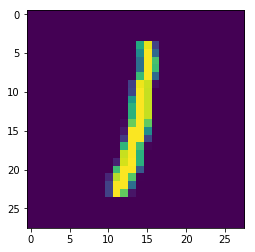

In [85]:
plt.imshow(mnist.train.images[4,:].reshape(28,28))

# CONSTRUCTION PHASE

In [86]:
tf.reset_default_graph()

In [87]:
# Define input
x = tf.placeholder(tf.float32,shape = [None,784]) 
# None, because we don't specify how many examples we'll look at

W = tf.Variable(tf.zeros([784, 10])) # number of weights
b = tf.Variable(tf.zeros([10])) # number of bias terms

In [88]:
y_hat = tf.nn.softmax(tf.matmul(x, W) + b) 
# define what we'll take the softmax activation on

# Notice order on x and W (dimensions must match)

In [89]:
# correct answers

y = tf.placeholder(tf.float32, [None, 10])

In [90]:
# define loss function
# Cross entropy

ce = tf.reduce_mean(-tf.reduce_sum( y* tf.log(y_hat),axis=1))

In [91]:
ce # sum over the columns to get cost for every training example

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [92]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(ce)

In [93]:
# monitor accuracy
def acc():
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_hat,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

# EXECUTION PHASE

In [94]:
sess = tf.Session()

In [95]:
sess.run(tf.global_variables_initializer())

In [96]:
for i in range(1000):
    # get batches of training data
    # we don't show everything to the network at once
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    if i%100==0:
        acc()

0.2581
0.8878
0.9048
0.9082
0.9088
0.9141
0.9147
0.9173
0.9154
0.9116


In [97]:
acc()

0.9211


In [ ]:
show_graph(tf.get_default_graph()) #not that great, we should probably use scopes

# Deep MINST

Example from the book `Hands-On Machine Learning with Scikit-Learn and TensorFlow`.

#### Improve the one layer model above, by adding extra layers with ReLU activation functions

In [ ]:
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# tf.learn (high level API)

Predefined models, for convenience. This is for fast model building when you have a standard problem.

In [ ]:
# Read input_data (not as one_hot)
from tensorflow.examples.tutorials.mnist import input_data

# new folder
mnist = input_data.read_data_sets("/tmp/data/")

# Assign them to values
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

# CONSTRUCTION PHASE

In [ ]:
# define features
feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)

# dense neural network classifier
# two layers 300 and 100
# 10 clases
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                         feature_columns=feature_cols)

# if TensorFlow >= 1.1, make compatible with sklearn
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) 

# EVALUATION PHASE

In [ ]:
# fit the model, 4000 iterations
dnn_clf.fit(X_train, y_train, batch_size=50, steps=1000)

In [ ]:
# Calculate accuracies
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test)
print()
print('Accuracy',accuracy_score(y_test, y_pred['classes']))

_____

# Let's build a DNN with 2 hidden layers from scratch

This is great for understanding!

# CONSTRUCTION PHASE

In [ ]:
# Define hyperparameters and input size

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [ ]:
# Reset graph
tf.reset_default_graph()

In [ ]:
# Placeholders for data (inputs and targets)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [ ]:
# Define neuron layers (ReLU in hidden layers)
# We'll take care of Softmax for output with loss function

def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # Output from every neuron
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [ ]:
# Define the hidden layers
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

In [ ]:
# Define loss function (that also optimizes Softmax for output):

with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [ ]:
# Training step with Gradient Descent

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [ ]:
# Evaluation to see accuracy

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Show graph

In [ ]:
show_graph(tf.get_default_graph())

# EVALUATION PHASE

# Train steps

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 3
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt") # save model

# Evaluate accuracy

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])

In [ ]:
show_graph(tf.get_default_graph())